<a href="https://colab.research.google.com/github/PatrickPLi/TrafficSignRecognition/blob/master/Traffic_Sign_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing the dataset

Download zip file containing training dataset. In this case, we will use the German Traffic Sign dataset as it is popular, large, and easy-to-use. If we wanted to use our own dataset in the future, that can easily be done through simple modifications to this code.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

np.random.seed(0)

!git clone https://bitbucket.org/jadslim/german-traffic-signs/German-Traffic-Signs-Classification/blob/master/signnames.csv


Using TensorFlow backend.


Cloning into 'signnames.csv'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [0]:
with open('signnames.csv/train.p','rb') as f:
    train_data = pickle.load(f)
with open('signnames.csv/valid.p','rb') as f:
    val_data = pickle.load(f)  
with open('signnames.csv/test.p','rb') as f:
    test_data = pickle.load(f)
    
x = train_data['labels']
y = val_data['labels']
z = test_data['labels']
X_train, y_train = train_data['features'][np.all([(x > 12), (x < 15)], axis = 0)], train_data['labels'][np.all([(x > 12), (x < 15)], axis = 0)]
X_val, y_val = val_data['features'][np.all([(y > 12), (y < 15)], axis = 0)], val_data['labels'][np.all([(y > 12), (y < 15)], axis = 0)]
X_test, y_test = test_data['features'][np.all([(z > 12), (z < 15)], axis = 0)], test_data['labels'][np.all([(z > 12), (z < 15)], axis = 0)]

data = pd.read_csv('signnames.csv/signnames.csv')
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

(2610, 32, 32, 3)
(330, 32, 32, 3)
(990, 32, 32, 3)


## Building The Model

But before we continue, let's start defining the model:

Step 1 will be to import tensorflow.

In [0]:
import tensorflow as tf

We then add convolutional layers and flatten the final result to feed into the densely connected layers.

In [0]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first and second convolution + pooling
    tf.keras.layers.Conv2D(60, (3,3), activation='relu', input_shape=(32, 32, 1)),
    tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The third and fourth convolution + pooling
    tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(30, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # One output neuron per class
    tf.keras.layers.Dense(43, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


The model.summary() method call prints a summary of the NN 

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 60)        600       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 30)        16230     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 30)        8130      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        8130      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 30)          0         
_________________________________________________________________
flatten (Flatten)            (None, 750)               0         
__________

The "output shape" column shows how the size of the feature map evolves in each successive layer. The convolution layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions.

Next, we'll configure the specifications for model training. We will train our model with the `categorical_crossentropy` loss, because it's a categorical classification problem. We will use the `adam` optimizer.

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

### Data Preprocessing
Data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

(2610, 32, 32)


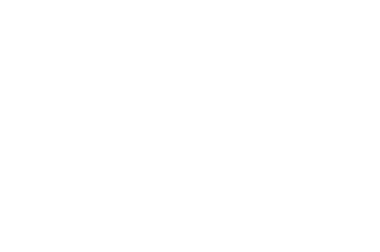

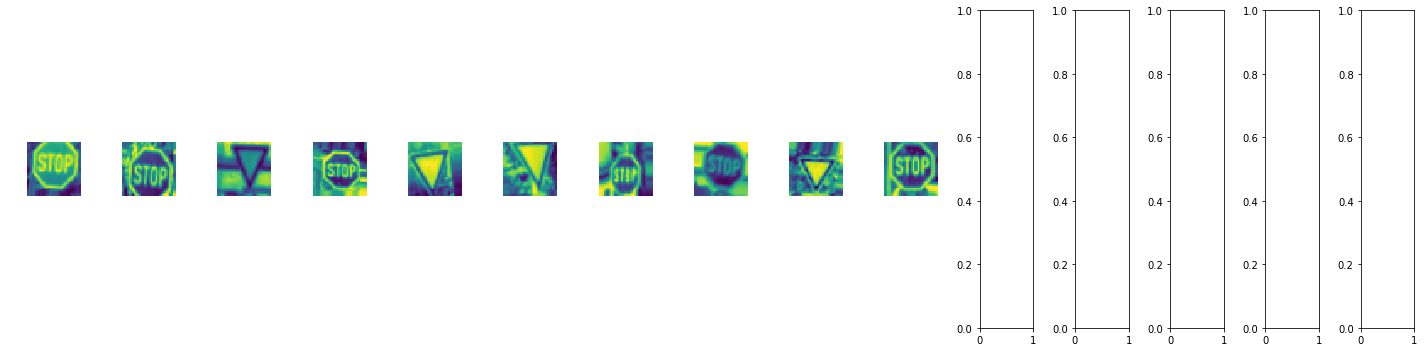

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img
  
def grayscale(img):
  image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  plt.axis('off')
  return image

def equalize(img):
  img = cv2.equalizeHist(img)
  return img

x = train_data['labels']
y = val_data['labels']
z = test_data['labels']
X_train, y_train = train_data['features'][np.all([(x > 12), (x < 15)], axis = 0)], train_data['labels'][np.all([(x > 12), (x < 15)], axis = 0)]
X_val, y_val = val_data['features'][np.all([(y > 12), (y < 15)], axis = 0)], val_data['labels'][np.all([(y > 12), (y < 15)], axis = 0)]
X_test, y_test = test_data['features'][np.all([(z > 12), (z < 15)], axis = 0)], test_data['labels'][np.all([(z > 12), (z < 15)], axis = 0)]


X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

print(X_train.shape)

X_train = X_train.reshape(2610, 32, 32, 1)
X_val = X_val.reshape(330, 32, 32, 1)
X_test = X_test.reshape(990, 32, 32, 1)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                  zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(10):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')
  
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

### Training
Let's train for 15 epochs -- this may take a few minutes to run.

Do note the values per epoch.

The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses. 

In [0]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = 50), steps_per_epoch = 2000, epochs = 15, validation_data =(X_val, y_val), shuffle = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
53/53 [==============================] - 4s 80ms/step - loss: 0.8055 - acc: 0.7203 - val_loss: 0.2040 - val_acc: 0.9939
Epoch 2/15
53/53 [==============================] - 1s 26ms/step - loss: 0.1801 - acc: 0.9287 - val_loss: 0.0246 - val_acc: 0.9939
Epoch 3/15
53/53 [==============================] - 2s 29ms/step - loss: 0.0341 - acc: 0.9893 - val_loss: 8.3876e-04 - val_acc: 1.0000
Epoch 4/15
53/53 [==============================] - 1s 28ms/step - loss: 0.0168 - acc: 0.9943 - val_loss: 7.1705e-05 - val_acc: 1.0000
Epoch 5/15
53/53 [==============================] - 2s 28ms/step - loss: 0.0100 - acc: 0.9969 - val_loss: 5.2302e-05 - val_acc: 1.0000
Epoch 6/15
53/53 [==============================] - 1s 28ms/step - loss: 0.0067 - acc: 0.9977 - val_loss: 1.6950e-04 - val_acc: 1.0000
Epoch 7/15
53/53 [==============================] - 2s 29ms/step - loss: 0.0076 - acc: 0.9973 - val_loss: 7.0942e-05 - val_acc: 1.0000
Epoch 8/15
53/5

###Plotting the training results
Next, we'll play the loss and accuracy metrics to see how our model improves through each epoch. Note how the trendlines seem to level off after around 4 epochs --- this indicates that the model is "converging."

Text(0.5, 0, 'epoch')

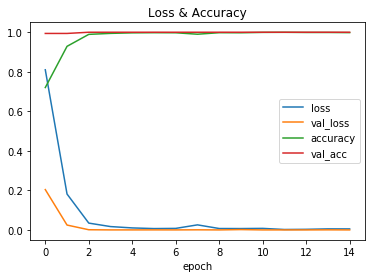

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['loss', 'val_loss', 'accuracy', 'val_acc'])
plt.title('Loss & Accuracy')
plt.xlabel('epoch')

##Making Predictions

Saving STOP_sign.jpg to STOP_sign.jpg
(32, 32, 3)
(32, 32)
predicted sign: 14
predicted sign: Stop


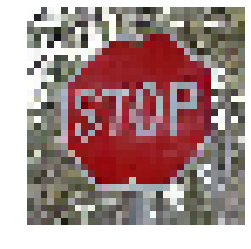

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(32, 32))
  plt.imshow(img, cmap = plt.get_cmap('gray'))
  img = np.asarray(img)
  print(img.shape)
  img = preprocessing(img)
  print(img.shape)
  img = img.reshape(1, 32, 32, 1)

  prediction = str(model.predict_classes(img))

  prediction = prediction[1:-1]

  pred = int(prediction)
  #plt.imshow(img)
  plt.axis('off')

for num, name in data.iteritems():
  name = name.values
  print("predicted sign: "+ str(name[pred]))

## Clean Up

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)